(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Analyzing hotel ratings on Tripadvisor

In this homework we will focus on practicing two techniques: web scraping and regression. For the first part, we will build upon the sample code from the Lecture and attempt to get some basic information for each hotel. Then, we will fit a regression model on this information and try to analyze it.   

One of the main disadvantages of scraping a website instead of using an API is that, without any notice, the website may change its layout and render our code useless. Something like that happened in our case. Tripadvisor changed the layout of the buttons that we use to navigate between the different pages of the results. This was the main reason people were having problem with executing the code.

**Task 1 (20 pts)**

The first task of the homework is to fix the scraping code. We basically need to replace the part where we are checking if there is another page and getting its link with new code that reflects the new navigation layout. 

** Task 2 (30 pts)**

Then, for each hotel that our search returns, we will "click" (with the code of course) on it and scrape the information below.

![Information to be scraped](hotel_info.png)

Of course, feel free to collect even more data if you want. 

** Task 3 (20 pts) **

Now, we will use regression to analyze this information. First, we will fit a linear regression model that predicts the average rating. For example, for the hotel above, the average rating is

$$ \text{AVG_SCORE} = \frac{1*31 + 2*33 + 3*98 + 4*504 + 5*1861}{2527}$$

Use the model to analyze the important factors that decide the $\text{AVG_SCORE}$.

** Task 4 (30 pts) **

Finally, we will use logistic regression to decide if a hotel is _excellent_ or not. We classify a hotel as _excellent_ if more than **60%** of its ratings are 5 stars. This is a binary attribute on which we can fit a logistic regression model. As before, use the model to analyze the data.

-------

In order to use code from a Python script file, we need to put that file in the same folder as the notebook and import it as a library. Then, we will be able to access it's functions. For example, in the case of the lecture code, we could do the following:

``` python
import scrape_solution as scrape

scrape.get_city_page()
```

Of course, you might need to modify and restructure the code so that it returns what you need.

----

In [2]:
import os
import sys
import time
import argparse
import logging
import requests
import pandas as pd
from BeautifulSoup import BeautifulSoup
from collections import defaultdict  # available in Python 2.5 and newer
import scrape_solution as scrape

In [63]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

In [3]:
##### this returns the hotel names and urls

def parse_hotellist_page(html1):
    soup = BeautifulSoup(html1)
    hotel_boxes = soup.findAll('div', {'class' :'listing wrap reasoning_v5_wrap jfy_listing p13n_imperfect'})
    if not hotel_boxes:
        hotel_boxes = soup.findAll('div', {'class' :'listing_info jfy'})
    if not hotel_boxes:
        hotel_boxes = soup.findAll('div', {'class' :'listing easyClear  p13n_imperfect'})
    for hotel_box in hotel_boxes:
        hotel_name = hotel_box.find("a", {"target" : "_blank"}).find(text=True)
        hotel_url = hotel_box.find("a", {"target" : "_blank"})['href']
        stars = hotel_box.find("img", {"class" : "sprite-ratings"})
        n_stars = stars['alt'].split()[0] 
        num_reviews = hotel_box.find("span", {'class': "more"}).findAll(text=True)
        n_reviews = [x for x in num_reviews if "review" in x][0].strip().split()[0]
        hotel_names[hotel_name.strip()] = n_stars, n_reviews, hotel_url

In [4]:
#### i created this method to get the urls of all the pages for a city

def get_page_links(html1):
    soup = BeautifulSoup(html1)
    div = soup.find("div", {"class" : "pgLinks"}) # or pgLinks
    # check if this is the last page
    if div.find('span', {'class' : 'guiArw pageEndNext'}):
        return ;
        print "we reached the end"
    else:
        hrefs_html = div.findAll('a', href= True)
        hrefs = set()
        for href in hrefs_html:
            link = href['href']
            hrefs.add(link)
        return hrefs

In [5]:
##### helper method to get number of hotels

def get_hotel_count(html1):
    soup = BeautifulSoup(html1)
    count_div= soup.find("div", {"class":"orphan   hotelsCount"})
    count = count_div.contents[1].string
    return count

In [1]:
# gets the data on review breakdown by rating, type, and sumamrize

def scrape_data(city_url):
    base_url = "http://www.tripadvisor.com/"
    url = base_url + city_url
    user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.76 Safari/537.36"
    headers = {'User-Agent': user_agent}
    response = requests.get(url, headers=headers)
    if response != 200:
        html = response.text.encode('utf-8')
    soup = BeautifulSoup(html)
    info_box = soup.find('div', {'class' :'content wrap trip_type_layout'})
    ratings_html = info_box.findAll('div',{'class':'wrap row'})
    review_type_html = info_box.find('div',{'class':'trip_type'})\
    .findAll('div',{'class':'filter_connection_wrapper'})
    summary_html = info_box.find('div',{'class':'wrap subrating'}).findAll('li')
    ratings = {}
    review_type = {}
    summaries = {}
    for i in ratings_html:
        ratings[i.find('span',{'class':'text'}).find(text=True)]= \
            i.find('span',{'class':'compositeCount'}).find(text=True)
    for i in review_type_html:
        index = i.findAll(text=True)[1]
        value = i.findAll(text=True)[3]
        review_type[index] = value
    for i in summary_html:
        summaries[i.find('div',{'class':'name'}).find(text=True)] = \
            i.find("img")['alt'].split()[0]  
    data = ratings
    data.update(review_type)
    data.update(summaries)
    return data

In [24]:
base_url = "http://www.tripadvisor.com/"
city_url = scrape.get_city_page("boston","massachusetts","")
url = base_url + city_url
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.76 Safari/537.36"
headers = {'User-Agent': user_agent}
response = requests.get(url, headers=headers)
if response != 200:
    html = response.text.encode('utf-8')
soup = BeautifulSoup(html)

hotel_names = {}
hrefs = get_page_links(html)
hrefs.add(city_url)
count = get_hotel_count(html)
print count
print hrefs
for i in hrefs:
    url = base_url + i
    response = requests.get(url, headers=headers)
    time.sleep(2)
    html = response.text.encode('utf-8')
    if response != 200:
        html = response.text.encode('utf-8')
    parse_hotellist_page(html)
    scraped = len(hotel_names)    

77
set([u'/Hotels-g60745-oa60-Boston_Massachusetts-Hotels.html#ACCOM_OVERVIEW', u'/Hotels-g60745-Boston_Massachusetts-Hotels.html', u'/Hotels-g60745-oa30-Boston_Massachusetts-Hotels.html#ACCOM_OVERVIEW'])


In [59]:
print len(hotel_names)
all_data = []
for i in hotel_names:
    data = scrape_data(hotel_names[i][2])
    data['reviews'] = hotel_names[i][1]
    data['stars'] = hotel_names[i][0]
    all_data.append(data)

70


In [205]:
df = pd.DataFrame(all_data, index= hotel_names.keys())
new_column_names = [ x.lower().replace(' ','_') for x in df.columns]
df.columns = new_column_names
for x in df.columns:
    df[x] = df[x].str.replace(r'[,]', '').astype('float')
df['average_score'] = ((df.excellent * 5) + (df.very_good * 4) + (df.average * 3) + (df.poor * 2) + (df.terrible * 1)) / df.reviews
df1 = df[['excellent','very_good','average','poor','terrible','reviews','average_score']]
df2 = df[['families','couples','solo','business']]
df3 = df[['sleep_quality','location','rooms','service','value','cleanliness']]
df3.head()

,sleep_quality,location,rooms,service,value,cleanliness
Hotel Commonwealth,5.0,5.0,5.0,5.0,4.5,5.0
"The Fairmont Copley Plaza, Boston",4.5,5.0,4.0,4.5,4.0,4.5
Onyx Hotel - a Kimpton Hotel,4.5,4.5,4.0,4.5,4.0,4.5
Residence Inn by Marriott Boston Harbor on Tudor Wharf,4.5,4.5,4.5,4.5,4.0,4.5
Lenox Hotel,4.5,5.0,4.5,5.0,4.5,5.0


In [146]:
y = df.average_score
X = df3
print X.shape, y.shape
#plt.scatter(X, y, c="slategray")
model = sm.OLS(y, X)
results = model.fit()
print results.summary()
print "Confidence Intervals:", results.conf_int()
print "Parameters:", results.params

(70, 6) (70L,)
                            OLS Regression Results                            
Dep. Variable:          average_score   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.709e+04
Date:                Sun, 05 Apr 2015   Prob (F-statistic):          1.54e-100
Time:                        02:02:30   Log-Likelihood:                 60.205
No. Observations:                  70   AIC:                            -108.4
Df Residuals:                      64   BIC:                            -94.92
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
sleep_quality     0.0841      0

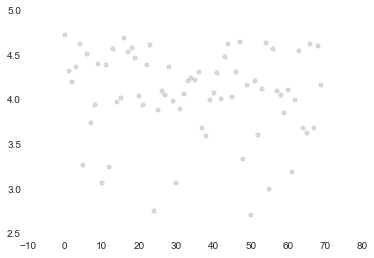

In [147]:
plt.scatter(range(len(y)), y, c="slategray", alpha=0.3, linewidths=0.2)

In [148]:
y = df.average_score
X = df3
X, y = utils.shuffle(X, y, random_state=1)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)
print(X_train.shape), y_train.shape
print(X_test.shape), y_test.shape

(42L, 6L) (42L,)
(28L, 6L) (28L,)


(70, 6) (70L,)
sleep_quality
(70, 6) (70L,)
location
(70, 6) (70L,)
rooms
(70, 6) (70L,)
service
(70, 6) (70L,)
value
(70, 6) (70L,)
cleanliness


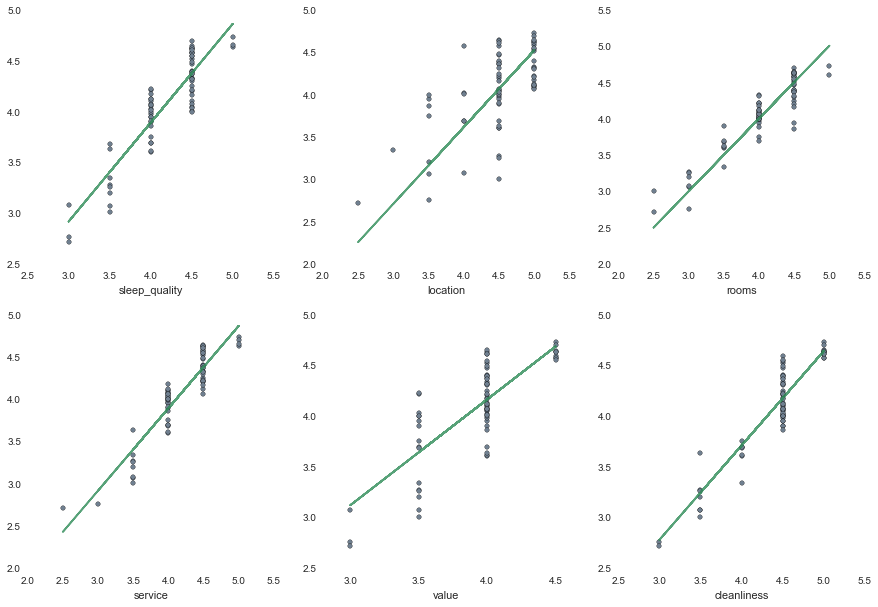

In [149]:
y = df.average_score
X = df3
idx = 0
fig, axes = plt.subplots(2,3,figsize=(15,10))
for i in X:
    Xi = X[i]
    row = idx / 3
    col = idx % 3
    print X.shape, y.shape
    #plt.scatter(X,y, c="slategray")
    model = sm.OLS(y, Xi)
    results = model.fit()
    axes[row][col].scatter(Xi,y, c="slategray")
    axes[row][col].plot(Xi,results.predict(Xi), c='seagreen', alpha=0.8)
#    axes[row][col].scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
#    axes[row][col].plot(subX_train,results.predict(subX_train), c='seagreen', alpha=0.8)
    axes[row][col].set_xlabel(i)
    idx = idx +1
    print i

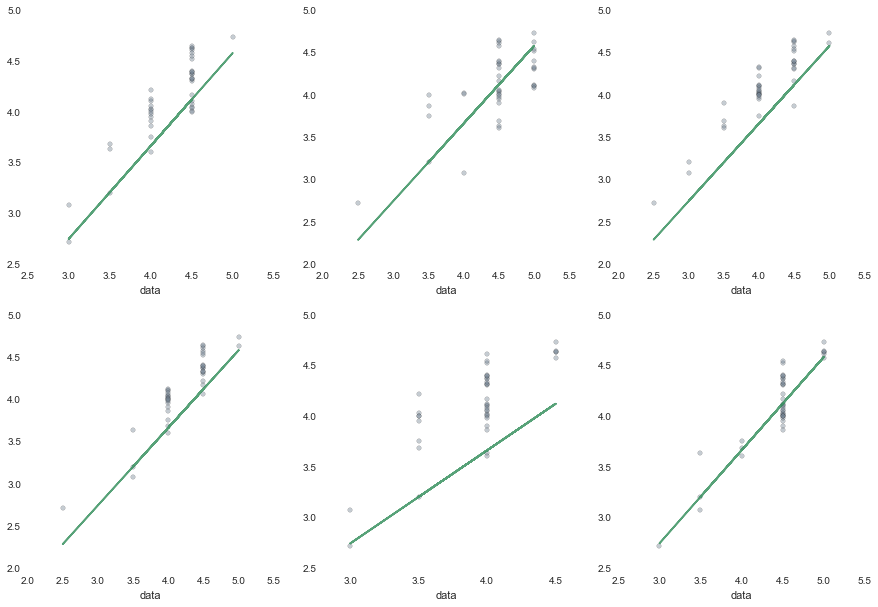

In [213]:
idx = 0
fig, axes = plt.subplots(2,3,figsize=(15,10))
for i in range(6):
#    Xi = X[i]
    subX_train = X_train[:,i]
    row = idx / 3
    col = idx % 3
    #plt.scatter(X,y, c="slategray")
    model = sm.OLS(y, Xi)
    results = model.fit()
    axes[row][col].scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
#    axes[row][col].scatter(Xi,y, c="slategray")
#    axes[row][col].plot(Xi,results.predict(Xi), c='seagreen', alpha=0.8)
    axes[row][col].plot(subX_train,results.predict(subX_train), c='seagreen', alpha=0.8)
    axes[row][col].set_xlabel('data')
    idx = idx +1

(42L, 6L) (42L,)
(28L, 6L) (28L,)


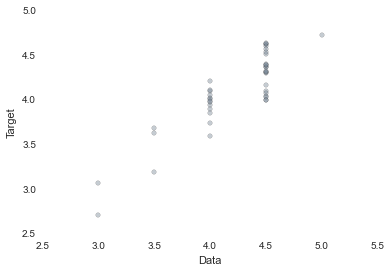

In [158]:
X, y = utils.shuffle(X, y, random_state=1)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)
print(X_train.shape), y_train.shape
print(X_test.shape), y_test.shape
subX_train = X_train[:,0]
subX_test = X_test[:,0]
plt.scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
# plt.scatter(subX_test, y_test, c="seagreen", alpha=0.2, linewidths=0.3)
plt.xlabel('Data')
plt.ylabel('Target');

regr = linear_model.LinearRegression()

In [159]:
regr = linear_model.LinearRegression()
print X_train.shape
regr.fit(X_train, y_train);
# The mean square error
print("Training error: ", metrics.mean_squared_error(regr.predict(X_train),y_train))
print("Test     error: ", metrics.mean_squared_error(regr.predict(X_test),y_test))

(42L, 6L)
('Training error: ', 0.0077995122068878747)
('Test     error: ', 0.012324819126557729)


In [161]:
train_score = regr.score(X_train,y_train)
test_score = regr.score(X_test,y_test)
print("Training score: ", train_score)
print("Test     score: ", test_score)
coefficients = regr.coef_
for i in range(len(coefficients)):
    print i,"\t",coefficients[i]

('Training score: ', 0.95601035490572539)
('Test     score: ', 0.96006300679599643)
0 	0.126212145065
1 	0.106350891606
2 	0.260981985345
3 	0.196645952882
4 	0.104336043417
5 	0.232707245739


In [162]:
regr = linear_model.LinearRegression()
scores = cross_validation.cross_val_score(regr, X, y, cv=5)
print scores
print("Regression score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.95074504  0.95066934  0.95424105  0.95786753  0.94285619]
Regression score: 0.95 (+/- 0.01)


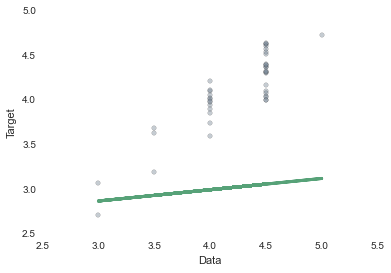

In [165]:
subX_train = X_train[:,0]
subX_test = X_test[:,0]
plt.scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
plt.plot(subX_train, coefficients[0]*subX_train+2.5, color='seagreen', linewidth=3, alpha=.8);
plt.xlabel('Data')
plt.ylabel('Target');

In [204]:
df4 = df
for i in df2:
    df4[i] = df2[i] / df.reviews
for i in df3:
    j = i + "_binary"
    df4[j] = (df3[i]==5).astype(int)
    
df4['excellent_binary'] = (((df4.sleep_quality_binary + df4.location_binary+ df4.rooms_binary + df4.service_binary + df4.value_binary + df4.cleanliness_binary) / 6.0) > 0.6).astype(int)
df4[['couples','families','solo','business']].head()


,couples,families,solo,business
Hotel Commonwealth,0.289643,0.310357,0.049915,0.198642
"The Fairmont Copley Plaza, Boston",0.345748,0.196151,0.044072,0.275605
Onyx Hotel - a Kimpton Hotel,0.379205,0.176351,0.056065,0.150866
Residence Inn by Marriott Boston Harbor on Tudor Wharf,0.269750,0.377649,0.048170,0.136802
Lenox Hotel,0.384256,0.246298,0.055729,0.149260


What I've done here is compute the percentages of each type of review and see whether there is a difference between excellent and non excellet groups by review type.

here we see that hotels for families are more often excellent.

In [209]:
df4[['couples','families','solo','business','excellent_binary']].groupby("excellent_binary").mean()

,couples,families,solo,business
excellent_binary,,,,
0,0.313144,0.219896,0.068550,0.214404
1,0.268853,0.296651,0.047729,0.252906


Same thing here except now with the criteria in the summary:

sleep quality, location, service, and cleanliness are all 5 for excellent, whereas rooms and value are lower in the 4s. 

In [211]:
df4[['sleep_quality','location','rooms','service','value','cleanliness','excellent_binary']].groupby("excellent_binary").mean()

,sleep_quality,location,rooms,service,value,cleanliness
excellent_binary,,,,,,
0,4.154412,4.455882,4.022059,4.154412,3.897059,4.367647
1,5.000000,5.000000,4.750000,5.000000,4.250000,5.000000


In [76]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../theme/custom.css", "r").read()
    return HTML()
css_styling()

<IPython.core.display.HTML object>